![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Classification using CNN: CIFAR10
- **Images**: 60,000 color images of size **(32x32)** in **10 categories**, with 6000 images per class. There are 50000 training images and 10000 test images.
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **Shape**: `(batch_size, 3, 32, 32)` → 3 channels (RGB).
  
![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


## 1️⃣ Dataset Class

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 50000, Testing samples: 10000


### Let's display some images

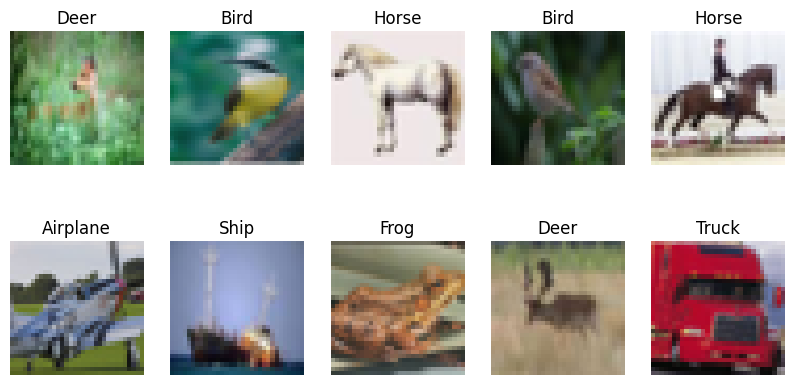

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)

    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.show()

In [4]:
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 32, 32)

Shape of one image tensor: torch.Size([3, 32, 32])


### 📊 Understanding CIFAR-10 Tensor Shape

**Shape:** `(batch_size, channels, height, width)` = `(32, 3, 32, 32)`

- **32** images per batch
- **3** color channels (Red, Green, Blue)
- **32×32** pixels per image

**Note:** Images are normalized to range [0, 1] when converted to tensors. We'll explore normalization techniques in the next lab!

### 📊 Grayscale vs RGB Tensors

remmeber **MNIST Shape:** `(batch_size, 1, 28, 28)`
- **1 channel** = grayscale (single intensity value per pixel)
- Values in range [0, 1] after `ToTensor()`

**Compare to RGB:** `(batch_size, 3, H, W)` 

- **3 channels** = color image (intensity values for R, G, B per pixel)
- Values in range [0, 1] after `ToTensor()`


## 2️⃣ Model Class

## CNN

In [5]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.relu(self.conv2(x)))  # (Batch, 32, 8, 8)
        x = self.pool(self.relu(self.conv3(x)))  # (Batch, 64, 4, 4)

        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits

        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)

### 📐 CNNModel Architecture Flow

```
Input (3, 32, 32)
    ↓
Conv1(3→16) + ReLU + Pool → (16, 16, 16)
    ↓
Conv2(16→32) + ReLU + Pool → (32, 8, 8)
    ↓
Conv3(32→64) + ReLU + Pool → (64, 4, 4)
    ↓
Flatten → (1024)
    ↓
FC1(1024→128) + ReLU
    ↓
FC2(128→10) → 10 classes
```

**Parameters:** ~140K trainable parameters

🎨 **[Visualize Architecture](https://poloclub.github.io/cnn-explainer/)** 

## AlexNet

### 🔍 AlexNet vs Simple CNN

| **Aspect** | **CNNModel** | **AlexNet32** |
|------------|--------------|---------------|
| **Conv Layers** | 3 | 5 |
| **FC Layers** | 2 | 3 |
| **Parameters** | ~140K | ~21M |
| **Dropout** | No | Yes |
| **Complexity** | Simple | Deep |

**Why AlexNet?** Originally designed for ImageNet (1000 classes, 224×224 images), adapted here for CIFAR-10. More parameters = more capacity to learn complex patterns, but also more prone to overfitting!

📄 **[AlexNet Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)** 

In [6]:
class AlexNet32(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet32, self).__init__()
        self.features = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=5),  # Output: 96 x 16 x 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 96 x 7 x 7

            nn.Conv2d(96, 256, kernel_size=5, padding=2),          # Output: 256 x 7 x 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # Output: 256 x 3 x 3

            nn.Conv2d(256, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),         # Output: 384 x 3 x 3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),         # Output: 256 x 3 x 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)                   # Output: 256 x 2 x 2
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 3️⃣ Training and Validation Loops

In [7]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


### 📐 Loss Function: Cross-Entropy

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log(\hat{y}_{\text{true class}})
$$

**PyTorch's `CrossEntropyLoss`** combines `LogSoftmax` + `NLLLoss`, so we pass raw logits (no softmax needed in model)!

🎮 **[Loss Visualizer](https://playground.tensorflow.org/)** | 📖 **[Detailed Explanation](../Extras/Day1_Extras.ipynb)**

## 4️⃣ Running Training

In [8]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:15<00:00, 101.19it/s]


Epoch 1/10: Train Loss=1.5931, Train Accuracy=41.76%, Val Loss=1.2880, Val Accuracy=53.65%


100%|██████████| 1563/1563 [00:14<00:00, 111.50it/s]


Epoch 2/10: Train Loss=1.2101, Train Accuracy=57.00%, Val Loss=1.1468, Val Accuracy=59.66%


100%|██████████| 1563/1563 [00:14<00:00, 108.09it/s]


Epoch 3/10: Train Loss=1.0341, Train Accuracy=63.63%, Val Loss=1.0218, Val Accuracy=63.26%


100%|██████████| 1563/1563 [00:13<00:00, 111.90it/s]


Epoch 4/10: Train Loss=0.9331, Train Accuracy=67.05%, Val Loss=0.9421, Val Accuracy=66.52%


100%|██████████| 1563/1563 [00:14<00:00, 110.65it/s]


Epoch 5/10: Train Loss=0.8525, Train Accuracy=69.87%, Val Loss=0.9229, Val Accuracy=68.21%


100%|██████████| 1563/1563 [00:14<00:00, 105.87it/s]


Epoch 6/10: Train Loss=0.7906, Train Accuracy=72.13%, Val Loss=0.8722, Val Accuracy=69.31%


100%|██████████| 1563/1563 [00:14<00:00, 111.58it/s]


Epoch 7/10: Train Loss=0.7385, Train Accuracy=73.88%, Val Loss=0.8870, Val Accuracy=69.51%


100%|██████████| 1563/1563 [00:13<00:00, 111.74it/s]


Epoch 8/10: Train Loss=0.6885, Train Accuracy=75.70%, Val Loss=0.9023, Val Accuracy=69.44%


100%|██████████| 1563/1563 [00:14<00:00, 111.09it/s]


Epoch 9/10: Train Loss=0.6493, Train Accuracy=77.13%, Val Loss=0.8696, Val Accuracy=70.75%


100%|██████████| 1563/1563 [00:13<00:00, 112.64it/s]


Epoch 10/10: Train Loss=0.6101, Train Accuracy=78.38%, Val Loss=0.8374, Val Accuracy=71.89%


### Plot loss and some predictions

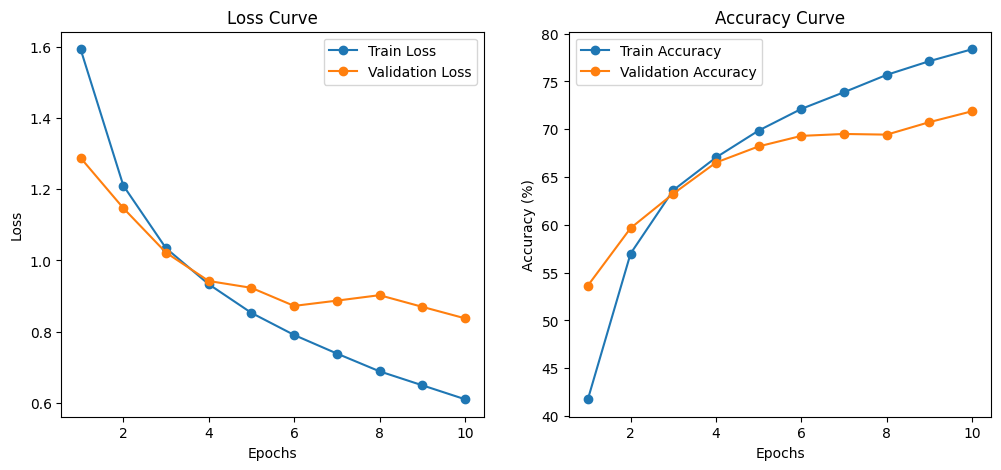

In [9]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


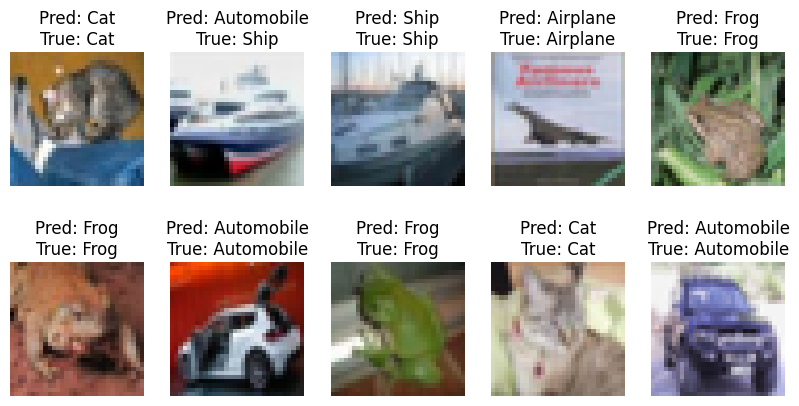

In [10]:
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    # CIFAR-10 class names
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, test_loader, device)


## 4️⃣ Running Training On AlexNet


In [11]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelAlex = AlexNet32(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(modelAlex.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(modelAlex, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(modelAlex, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:29<00:00, 52.13it/s]


Epoch 1/10: Train Loss=1.9414, Train Accuracy=24.50%, Val Loss=1.6955, Val Accuracy=35.28%


100%|██████████| 1563/1563 [00:30<00:00, 52.04it/s]


Epoch 2/10: Train Loss=1.6438, Train Accuracy=38.68%, Val Loss=1.5593, Val Accuracy=41.43%


100%|██████████| 1563/1563 [00:30<00:00, 51.04it/s]


Epoch 3/10: Train Loss=1.5271, Train Accuracy=44.51%, Val Loss=1.4568, Val Accuracy=46.53%


100%|██████████| 1563/1563 [00:29<00:00, 52.28it/s]


Epoch 4/10: Train Loss=1.4344, Train Accuracy=48.50%, Val Loss=1.3957, Val Accuracy=48.45%


 13%|█▎        | 201/1563 [00:04<00:29, 46.90it/s]


KeyboardInterrupt: 

### Plot loss and some predictions

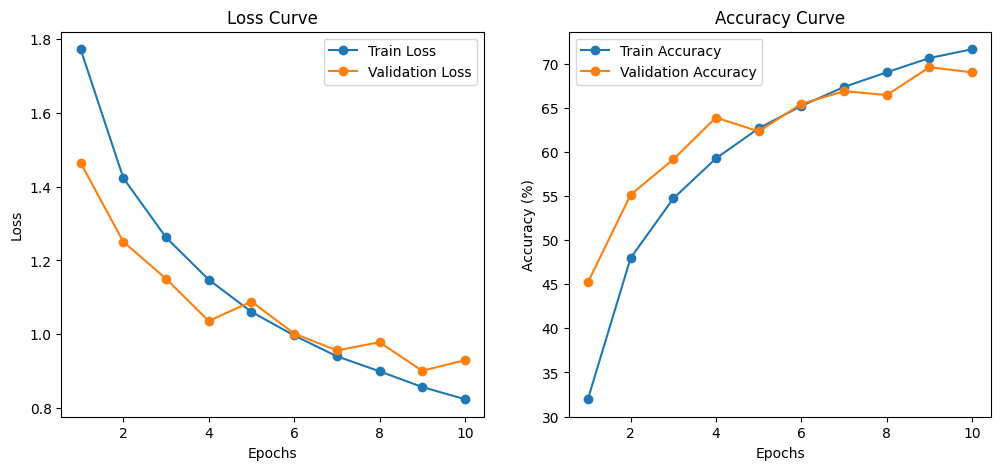

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


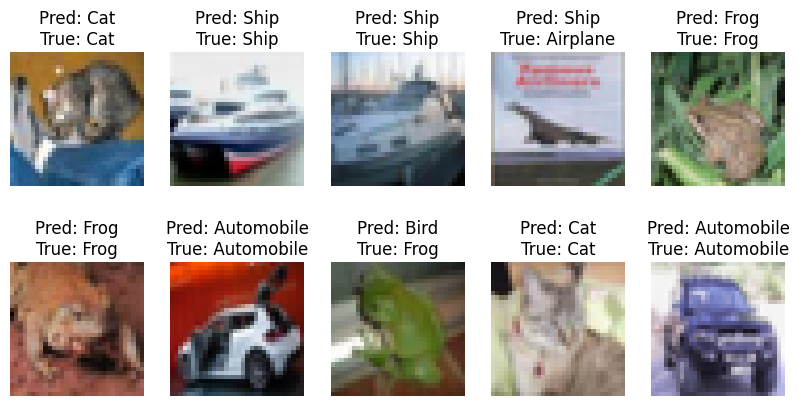

In [ ]:
# Show predictions
show_predictions(modelAlex, test_loader, device)


### Contributed by: Mohamed Eltayeb & Ali Habibullah


#### Edited by: Abdulellah Mojalled

![image.png](https://i.imgur.com/a3uAqnb.png)